## 1. Problem Setup: Imports and Physical Parameters

This section sets up:
- The required Python libraries: `numpy`, `matplotlib`, `scipy.linalg.solve_banded`, and `scipy.special.erf`.
- Defines the **physical parameters** of the problem:
  - `L`: Length of the tunnel (m)
  - `v`: Wind speed through the tunnel (m/s)
  - `D`: Diffusion coefficient (m²/s)
  - `T_final`: Total simulation time (s)

It also defines the **true analytical solution** to the advection-diffusion equation, as well as the **initial condition**.



In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.special import erf

# Problem Parameters
L = 5.0           # Length of tunnel [m]
v = 2.5           # Wind speed [m/s]
D = 0.02          # Diffusion coefficient [m^2/s]
T_final = 1.0     # Final simulation time [s]

# True Solution
def true_solution(x, t):
    if t == 0:
        return np.zeros_like(x)
    return 0.5 * (1 - erf((x - v*t) / (2 * np.sqrt(D*t))))

# Initial Condition
def true_solution_initial(x):
    return np.zeros_like(x)


## 2. Numerical Solver: Crank-Nicolson Scheme for Advection-Diffusion

This function implements a **Crank-Nicolson finite difference method** to solve the 1D advection-diffusion equation.
- Sets up the **spatial and temporal grids**.
- Forms the **banded matrix** corresponding to the implicit Crank-Nicolson system.
- Applies **Dirichlet boundary condition** at the inlet (`u=1`) and **Neumann boundary condition** (zero-gradient) at the outlet.

It returns:
- `x`: Spatial grid
- `t`: Temporal grid
- `u`: Computed numerical solution array


In [2]:
# Numerical Solver using Crank-Nicolson for Advection-Diffusion
def advection_diffusion_CN(Nx, Nt):
    dx = L / (Nx-1)
    dt = T_final / (Nt-1)
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T_final, Nt)

    u = np.zeros((Nt, Nx))
    u[0, :] = true_solution_initial(x)

    r_adv = v * dt / (2*dx)
    r_diff = D * dt / (dx**2)

    lower = -r_diff/2 - r_adv/2
    diag  = 1 + r_diff
    upper = -r_diff/2 + r_adv/2

    A_banded = np.zeros((3, Nx-2))
    A_banded[0,1:] = upper
    A_banded[1,:] = diag
    A_banded[2,:-1] = lower

    for n in range(0, Nt-1):
        rhs = (r_diff/2 + r_adv/2)*u[n,0:-2] + (1 - r_diff)*u[n,1:-1] + (r_diff/2 - r_adv/2)*u[n,2:]
        rhs[0] += (r_diff/2 + r_adv/2)*1.0

        u_new_inner = solve_banded((1,1), A_banded, rhs)

        u[n+1,0] = 1.0
        u[n+1,1:-1] = u_new_inner
        u[n+1,-1] = u[n+1,-2]

    return x, t, u


## 3. Error Computation: Relative and Absolute $L^2$ Norms

This function computes the error between the **numerical** and **true analytical solution** over the entire space-time domain.

Two options:
- **Relative error** (default): $\frac{|| u_{\text{true}} - u_{\text{num}} ||_2}{|| u_{\text{true}} ||_2}$
- **Absolute error**: $|| u_{\text{true}} - u_{\text{num}} ||_2$


In [3]:
# Error Analysis (Relative and Absolute L2 Error)
def compute_errors(u_num, x, t, return_relative=True):
    Nt, Nx = u_num.shape
    u_true = np.zeros_like(u_num)
    for n in range(Nt):
        u_true[n,:] = true_solution(x, t[n])
    num = np.linalg.norm(u_true - u_num, ord=2)
    if return_relative:
        denom = np.linalg.norm(u_true, ord=2)
        return num / denom
    else:
        return num


## 4. Spatial Convergence Study

This function studies how the **spatial grid refinement ($\Delta x$)** affects the error.
- Runs simulations for multiple values of `Nx`.
- Computes both **relative** and **absolute** errors.
- Plots:
  - Relative error vs $\Delta x$
  - Absolute error vs $\Delta x$ with a reference line showing $\mathcal{O}(\Delta x^2)$ behavior.


In [4]:
# Spatial Convergence Study
def convergence_study_spatial():
    rel_errors = []
    abs_errors = []
    dxs = []
    Nx_list = [10, 20, 30, 40, 50, 60, 70, 80]

    for Nx in Nx_list:
        dx = L / (Nx-1)
        dt = 0.001
        Nt = int(T_final/dt) + 1
        x, t, u = advection_diffusion_CN(Nx, Nt)
        rel_error = compute_errors(u, x, t, return_relative=True)
        abs_error = compute_errors(u, x, t, return_relative=False)
        rel_errors.append(rel_error)
        abs_errors.append(abs_error)
        dxs.append(dx)

    dxs = np.array(dxs)
    rel_errors = np.array(rel_errors)
    abs_errors = np.array(abs_errors)

    plt.figure()
    plt.loglog(dxs, rel_errors, 'o-', label='Relative Spatial Error')
    plt.xlabel(r'$\Delta x$')
    plt.ylabel('Relative $L^2$ Error')
    plt.grid(True)
    plt.legend()
    plt.title('Spatial Convergence Study (Relative Error)')
    plt.show()

    plt.figure()
    plt.loglog(dxs, abs_errors, 's-', label='Absolute Spatial Error')
    plt.loglog(dxs, [abs_errors[-1]*(dx/dxs[-1])**2 for dx in dxs], '--', label=r'$\mathcal{O}(\Delta x^2)$')
    plt.xlabel(r'$\Delta x$')
    plt.ylabel('Absolute $L^2$ Error')
    plt.grid(True)
    plt.legend()
    plt.title('Spatial Convergence Study (Absolute Error)')
    plt.show()


## 5. Temporal Convergence Study

This function studies how the **time step refinement ($\Delta t$)** affects the error:
- Uses a fine spatial resolution (`Nx=2001`) to focus purely on temporal effects.
- Runs simulations for various time steps (`dt` values).
- Computes and plots:
  - Relative error vs $\Delta t$
  - Absolute error vs $\Delta t$ with a reference line showing $\mathcal{O}(\Delta t^2)$ behavior.


In [5]:
# Temporal Convergence Study
def convergence_study_temporal():
    rel_errors = []
    abs_errors = []
    dts = []
    Nx = 2001

    dt_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02]
    for dt in dt_list:
        Nt = int(T_final/dt) + 1
        x, t, u = advection_diffusion_CN(Nx, Nt)
        rel_error = compute_errors(u, x, t, return_relative=True)
        abs_error = compute_errors(u, x, t, return_relative=False)
        rel_errors.append(rel_error)
        abs_errors.append(abs_error)
        dts.append(dt)

    dts = np.array(dts)
    rel_errors = np.array(rel_errors)
    abs_errors = np.array(abs_errors)

    plt.figure()
    plt.loglog(dts, rel_errors, 'o-', label='Relative Temporal Error')
    plt.xlabel(r'$\Delta t$')
    plt.ylabel('Relative $L^2$ Error')
    plt.grid(True)
    plt.legend()
    plt.title('Temporal Convergence Study (Relative Error)')
    plt.show()

    plt.figure()
    plt.loglog(dts, abs_errors, 's-', label='Absolute Temporal Error')
    plt.loglog(dts, [abs_errors[-1]*(dt/dts[-1])**2 for dt in dts], '--', label=r'$\mathcal{O}(\Delta t^2)$')
    plt.xlabel(r'$\Delta t$')
    plt.ylabel('Absolute $L^2$ Error')
    plt.grid(True)
    plt.legend()
    plt.title('Temporal Convergence Study (Absolute Error)')
    plt.show()


## 6. Front Location Tracking Over Time

This function tracks the **position of the pollutant front** over time.
- Finds where the concentration $u(x,t)$ crosses a **threshold value** (default 0.5).
- Plots the **front location vs time** to observe how it moves.


In [6]:
# Plotting Front Location over Time
def plot_front_location(x, t, u, threshold=0.5):
    front_positions = []
    for n in range(len(t)):
        idx = np.argmin(np.abs(u[n,:] - threshold))
        front_positions.append(x[idx])

    plt.figure(figsize=(8,6))
    plt.plot(t, front_positions, label=f'Front where u={threshold}')
    plt.xlabel('Time (s)')
    plt.ylabel('Front Location (m)')
    plt.grid(True)
    plt.title('Pollutant Front Location Over Time')
    plt.legend()
    plt.show()


## 7. Contour Plot of Concentration

This function produces a **contour plot** showing $u(x,t)$ over the domain.
- Uses `contourf` with a colorbar.
- Allows visualization of the pollutant concentration evolution over time and space.


In [7]:
# Contour Plot of Pollutant Concentration
def plot_contour(x, t, u):
    plt.figure(figsize=(8,6))
    X, T = np.meshgrid(x, t)
    plt.contourf(X, T, u, 50, cmap='viridis')
    plt.colorbar(label='Pollutant Concentration')
    plt.xlabel('x (m)')
    plt.ylabel('t (s)')
    plt.title('Contour of Pollutant Concentration')
    plt.show()


## 8. Numerical vs True Solution at Multiple Times

This function compares the **numerical** and **true solution** at selected times.
- Overlays numerical and true solution curves at several snapshots.
- Visualizes the accuracy of the numerical method over time.


In [8]:
# Compare Numerical and True Solution at Multiple Times
def plot_numerical_vs_true_multiple(x, t, u, time_indices=None):
    if time_indices is None:
        dt = t[1] - t[0]
        time_indices = [0, int(0.25*T_final/dt), int(0.5*T_final/dt), int(0.75*T_final/dt), -1]

    plt.figure(figsize=(10,7))
    for idx in time_indices:
        plt.plot(x, u[idx,:], label=f'Numerical t={t[idx]:.2f}')
        plt.plot(x, true_solution(x, t[idx]), '--', label=f'True t={t[idx]:.2f}')
    plt.xlabel('x (m)')
    plt.ylabel('Concentration')
    plt.title('Numerical vs True Solution at Multiple Times')
    plt.legend()
    plt.grid(True)
    plt.show()


## 9. Main Script: Running the Simulation and Plotting Results

This final cell:
- Sets the **spatial and temporal resolution**.
- Runs the solver.
- Calls the plotting and convergence study functions to **generate all results**.


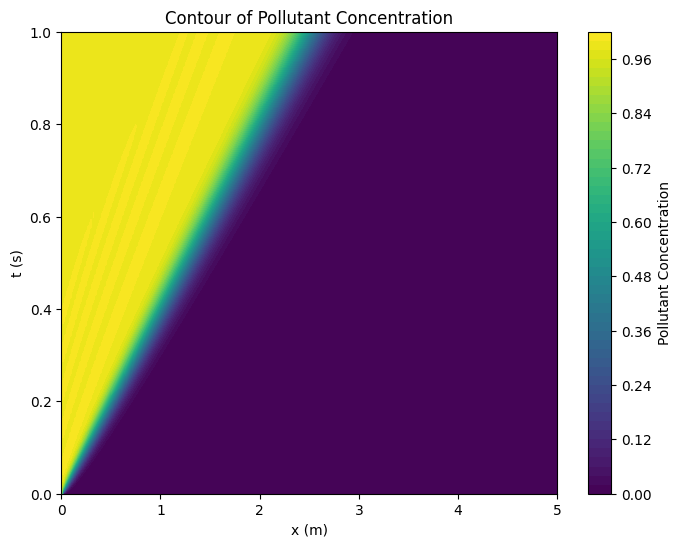

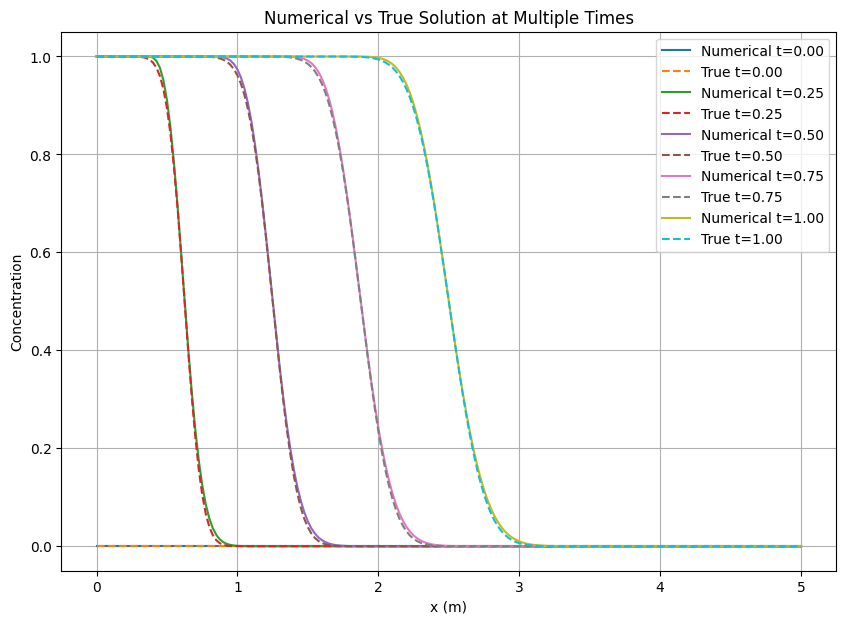

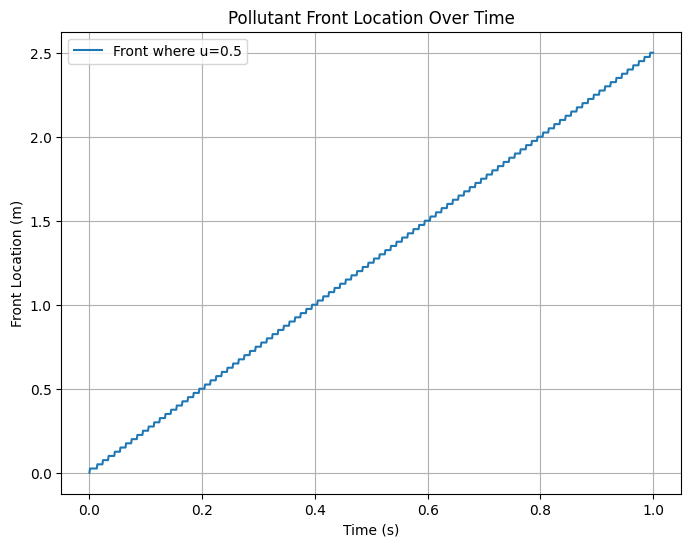

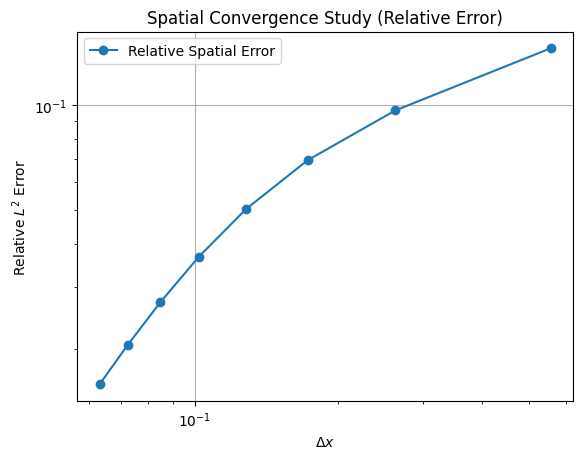

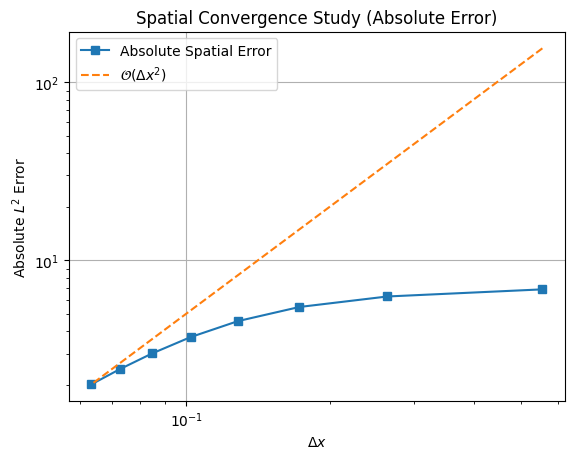

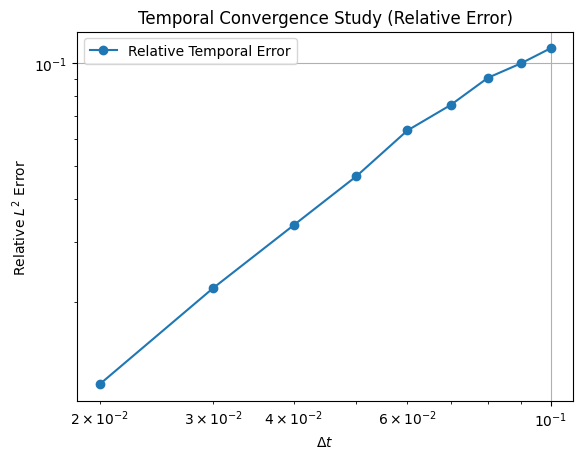

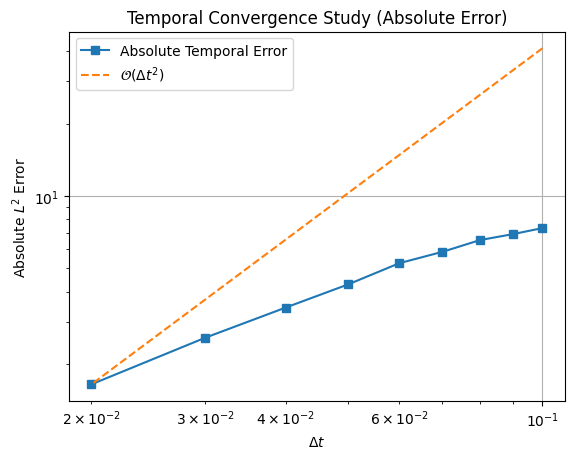

In [9]:
# === Main Execution ===
if __name__ == "__main__":
    Nx = 201
    dt = 0.001
    Nt = int(T_final/dt) + 1

    x, t, u = advection_diffusion_CN(Nx, Nt)

    plot_contour(x, t, u)
    plot_numerical_vs_true_multiple(x, t, u)
    plot_front_location(x, t, u)
    convergence_study_spatial()
    convergence_study_temporal()
